In [10]:
import numpy as np
path = "/home/pablo.canosa/ssd/datasets_pablo/rios_victor/images/eiras_dam.raw"
gt = "/home/pablo.canosa/ssd/datasets_pablo/rios_victor/gt/eiras_dam.pgm"

def read_rawPV(filename):
	# Lectura de imaxe Pixel-Vector en RAW
	imaxe = np.fromfile(filename, dtype='int32')
	B = imaxe[0]
	H = imaxe[1]
	V = imaxe[2]
	#Sacamos os datos da cabeceira e pasamos a 3D o array
	imaxe = imaxe[3:].reshape((V, H, B))

	return imaxe

def read_pgm(fichero):
	try:
		pgmf=open(fichero,"rb")
	except IOError:
		print('No puedo abrir ',fichero)
	else:
		assert pgmf.readline().decode()=='P5\n'
		line=pgmf.readline().decode()
	while(line[0]=='#'):
		line=pgmf.readline().decode()
	(H,V)=line.split()
	H=int(H); V=int(V)
	depth=int(pgmf.readline().decode())
	assert depth<=255
	raster=[]
	for i in range(H*V):
		raster.append(ord(pgmf.read(1)))
	print('* Read GT:',fichero)
	print('  H:',H,'V:',V,'depth:',depth)
	print('  Read:',len(raster))
	return(raster,H,V)

img = read_rawPV(path)
print('Image shape:', img.shape)
(truth,H1,V1)=read_pgm("/home/pablo.canosa/ssd/datasets_pablo/rios_victor/gt/eiras_dam.pgm")

Image shape: (5176, 18221, 5)
* Read GT: /home/pablo.canosa/ssd/datasets_pablo/rios_victor/gt/eiras_dam.pgm
  H: 18221 V: 5176 depth: 10
  Read: 94311896


(5176, 18221, 5)


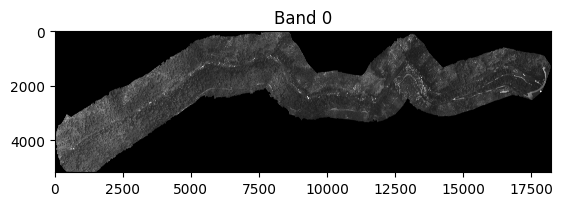

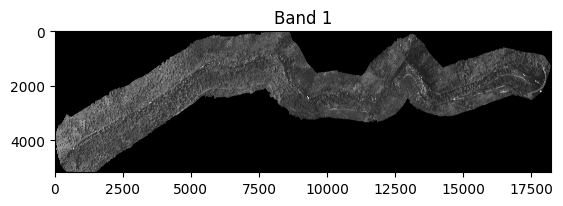

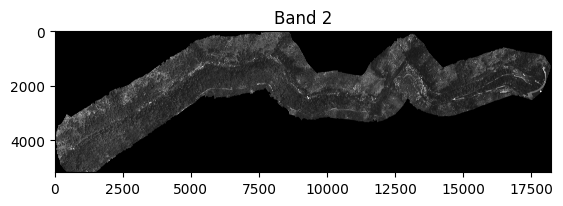

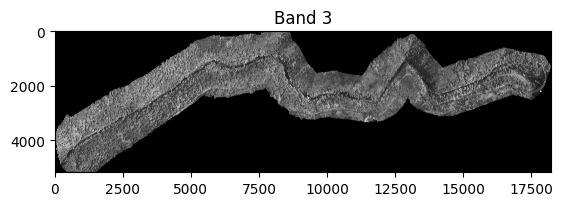

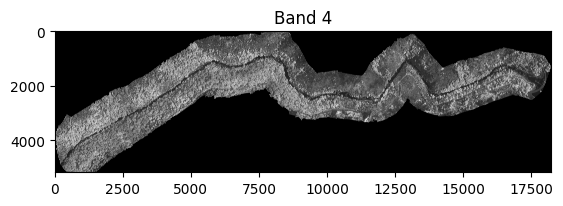

In [11]:
from matplotlib import pyplot as plt
print(img.shape)
for band in range(img.shape[2]):
    plt.imshow(img[:,:,band], cmap='gray')
    plt.title(f'Band {band}')
    plt.show()

94311896


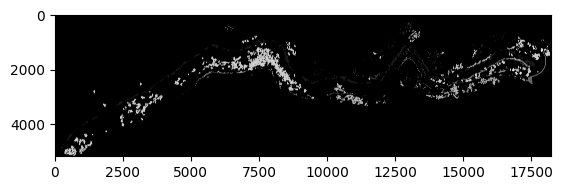

In [16]:
print(len(truth))
truth = np.array(truth).reshape((V1,H1))
plt.imshow(truth, cmap='gray')

In [ ]:
import os
import numpy as np


def read_rawPV(filename):
	# Lectura de imaxe Pixel-Vector en RAW
	imaxe = np.fromfile(filename, dtype='int32')
	B = imaxe[0]
	H = imaxe[1]
	V = imaxe[2]
	#Sacamos os datos da cabeceira e pasamos a 3D o array
	imaxe = imaxe[3:].reshape((V, H, B))

	return imaxe

def save_rawPV(imaxe, filename):
    V, H, B = imaxe.shape
    header = np.array([B, H, V], dtype='int32')
    data_to_save = np.concatenate((header, imaxe.flatten()))
    data_to_save.tofile(filename)
    print(f'Saved RAW image to {filename}')

def read_pgm(fichero):
	try:
		pgmf=open(fichero,"rb")
	except IOError:
		print('No puedo abrir ',fichero)
	else:
		assert pgmf.readline().decode()=='P5\n'
		line=pgmf.readline().decode()
	while(line[0]=='#'):
		line=pgmf.readline().decode()
	(H,V)=line.split()
	H=int(H); V=int(V)
	depth=int(pgmf.readline().decode())
	assert depth<=255
	raster=[]
	for i in range(H*V):
		raster.append(ord(pgmf.read(1)))
	print('* Read GT:',fichero)
	print('  H:',H,'V:',V,'depth:',depth)
	print('  Read:',len(raster))
	return(raster,H,V)

def save_pgm(output,H,V,nclases,filename):
    try:
        f=open(filename,"wb")
    except IOError:
        print('No puedo abrir ',filename)
        exit(0)
    else:
        # f.write(b'P5\n')
        cadena='P5\n'+str(H)+' '+str(V)+'\n'+str(nclases)+'\n'
        f.write(bytes(cadena,'utf-8'))
        f.write(output)
        f.close()
        print('* Saved file:',filename)


def create_square_patches(path, gt_path, side = 500):
    img = read_rawPV(path)
    (gt,H1,V1) = read_pgm(gt_path)
    gt = np.array(gt).reshape((V1,H1))
    V, H, B = img.shape
    patches = []
    for i in range(0, V, side):
        for j in range(0, H, side):
            patch_img = img[i:i+side, j:j+side, :]
            if patch_img.shape[0] == side and patch_img.shape[1] == side:
                #print(f'Patch {len(patches)} at ({i}, {j}) with shape {patch_img.shape}')
                patch_gt = gt[i:i+side, j:j+side]
                if(len(np.unique(patch_gt)) > 1): # make sure that gt is labeled
                    print(f"saving patch {len(patches)} with gt labels")
                    patches.append((patch_img, patch_gt))
    return patches

def save_patches(patches, river_name, base_path_img, base_path_gt):
    for idx, (patch_img, patch_gt) in enumerate(patches):
        img_filename = f"{base_path_img}{river_name}_patch_{idx}.raw"
        gt_filename = f"{base_path_gt}{river_name}_patch_{idx}.pgm"

        # Save image patch
        save_rawPV(patch_img, img_filename)
        # Save GT patch
        save_pgm(patch_gt.flatten().astype(np.uint8), patch_gt.shape[1], patch_gt.shape[0], nclases=10, filename=gt_filename)

def create_rios_dataset(path_img_dir_src, path_gt_dir_src, path_img_dir_dest, path_gt_dir_dest, side=500):
     for image_file in os.listdir(path_img_dir_src):
        if image_file.endswith('.raw'):
            river_name = image_file.replace('.raw', '')

            img_path = os.path.join(path_img_dir_src, image_file)
            gt_path = os.path.join(path_gt_dir_src, f"{river_name}.pgm")
            print(f"Processing {river_name}")
            patches = create_square_patches(img_path, gt_path, side)
            save_patches(patches, river_name, path_img_dir_dest, path_gt_dir_dest)





#path = "/home/pablo.canosa/ssd/datasets_pablo/rios_victor/images/eiras_dam.raw"
#gt_path = "/home/pablo.canosa/ssd/datasets_pablo/rios_victor/gt/eiras_dam.pgm"
#patches = create_square_patches(path, gt_path, side=500)

path_img_dir = "/home/pablo.canosa/ssd/datasets_pablo/rios_victor/images/"
path_gt_dir = "/home/pablo.canosa/ssd/datasets_pablo/rios_victor/gt/"

path_img_dest = "/home/pablo.canosa/ssd/datasets_pablo/rios_FBP/img/"
path_gt_dest = "/home/pablo.canosa/ssd/datasets_pablo/rios_FBP/gt/"

create_rios_dataset(path_img_dir, path_gt_dir, path_img_dest, path_gt_dest, side=500)


Processing ulla_river
* Read GT: /home/pablo.canosa/ssd/datasets_pablo/rios_victor/gt/ulla_river.pgm
  H: 16555 V: 4220 depth: 10
  Read: 69862100
saving patch 0 with gt labels
saving patch 1 with gt labels
saving patch 2 with gt labels
saving patch 3 with gt labels
saving patch 4 with gt labels
saving patch 5 with gt labels
saving patch 6 with gt labels
saving patch 7 with gt labels
saving patch 8 with gt labels
saving patch 9 with gt labels
saving patch 10 with gt labels
saving patch 11 with gt labels
saving patch 12 with gt labels
saving patch 13 with gt labels
saving patch 14 with gt labels
saving patch 15 with gt labels
saving patch 16 with gt labels
saving patch 17 with gt labels
saving patch 18 with gt labels
saving patch 19 with gt labels
saving patch 20 with gt labels
saving patch 21 with gt labels
saving patch 22 with gt labels
saving patch 23 with gt labels
saving patch 24 with gt labels
saving patch 25 with gt labels
saving patch 26 with gt labels
saving patch 27 with gt la

## Extra, convertir todos los GT a PNG

In [6]:
path_pgm = "/home/pablo.canosa/ssd/datasets_pablo/rios_FBP/gt/"
path_png = "/home/pablo.canosa/ssd/datasets_pablo/rios_FBP/png/"

import os
import numpy as np
import imageio.v2 as imageio  # use v2 for compatibility

for f in os.listdir(path_pgm):
    if f.endswith('.pgm'):
        truth, H1, V1 = read_pgm(os.path.join(path_pgm, f))
        truth = np.array(truth, dtype=np.uint8).reshape((V1, H1))
        imageio.imwrite(
            os.path.join(path_png, f.replace('.pgm', '.png')),
            truth
        )


* Read GT: /home/pablo.canosa/ssd/datasets_pablo/rios_FBP/gt/ferreiras_river_patch_148.pgm
  H: 500 V: 500 depth: 10
  Read: 250000
* Read GT: /home/pablo.canosa/ssd/datasets_pablo/rios_FBP/gt/ferreiras_river_patch_124.pgm
  H: 500 V: 500 depth: 10
  Read: 250000
* Read GT: /home/pablo.canosa/ssd/datasets_pablo/rios_FBP/gt/eiras_dam_patch_89.pgm
  H: 500 V: 500 depth: 10
  Read: 250000
* Read GT: /home/pablo.canosa/ssd/datasets_pablo/rios_FBP/gt/ermidas_creek_patch_171.pgm
  H: 500 V: 500 depth: 10
  Read: 250000
* Read GT: /home/pablo.canosa/ssd/datasets_pablo/rios_FBP/gt/mera_river_patch_79.pgm
  H: 500 V: 500 depth: 10
  Read: 250000
* Read GT: /home/pablo.canosa/ssd/datasets_pablo/rios_FBP/gt/xesta_basin_patch_103.pgm
  H: 500 V: 500 depth: 10
  Read: 250000
* Read GT: /home/pablo.canosa/ssd/datasets_pablo/rios_FBP/gt/ermidas_creek_patch_17.pgm
  H: 500 V: 500 depth: 10
  Read: 250000
* Read GT: /home/pablo.canosa/ssd/datasets_pablo/rios_FBP/gt/oitaven_river_patch_37.pgm
  H: 500 V

In [10]:
# read a random png image and show the unique values
img = imageio.imread("/home/pablo.canosa/ssd/datasets_pablo/rios_FBP/png/eiras_dam_patch_133.png")
print(np.unique(img))


[0 2 7]


In [ ]:
path_img = "/home/pablo.canosa/ssd/datasets_pablo/rios_FBP/img/"
path_img_test = "/home/pablo.canosa/ssd/datasets_pablo/rios_FBP/img_test/"

path_png = "/home/pablo.canosa/ssd/datasets_pablo/rios_FBP/png/"
path_png_test = "/home/pablo.canosa/ssd/datasets_pablo/rios_FBP/png_test/"

import os

img_names = []
for f in os.listdir(path_img):
    img_names.append(f)

print(len(img_names))

# get random 15% of the images
import random
random.seed(42)
img_names_test = random.sample(img_names, int(0.15*len(img_names)))
print(len(img_names_test))
img_names_train = [f for f in img_names if f not in img_names_test]
print(img_names_test)



1442
216
['xesta_basin_patch_137.raw', 'ulla_river_patch_7.raw', 'ferreiras_river_patch_166.raw', 'eiras_dam_patch_98.raw', 'ermidas_creek_patch_45.raw', 'mera_river_patch_53.raw', 'oitaven_river_patch_78.raw', 'oitaven_river_patch_12.raw', 'mera_river_patch_118.raw', 'ermidas_creek_patch_78.raw', 'mera_river_patch_80.raw', 'mera_river_patch_5.raw', 'mera_river_patch_214.raw', 'ferreiras_river_patch_126.raw', 'xesta_basin_patch_127.raw', 'eiras_dam_patch_63.raw', 'eiras_dam_patch_149.raw', 'ulla_river_patch_9.raw', 'mera_river_patch_306.raw', 'das_mestas_river_patch_99.raw', 'mera_river_patch_194.raw', 'mera_river_patch_268.raw', 'mera_river_patch_26.raw', 'ermidas_creek_patch_158.raw', 'oitaven_river_patch_19.raw', 'das_mestas_river_patch_93.raw', 'mera_river_patch_391.raw', 'mera_river_patch_106.raw', 'xesta_basin_patch_52.raw', 'oitaven_river_patch_2.raw', 'ferreiras_river_patch_9.raw', 'ulla_river_patch_6.raw', 'ferreiras_river_patch_158.raw', 'das_mestas_river_patch_42.raw', 'mera

In [ ]:
# Move the test images to the test folder
import shutil
for f in img_names_test:
    shutil.move(os.path.join(path_img, f), os.path.join(path_img_test, f))
    shutil.move(os.path.join(path_png, f.replace('.raw', '.png')), os.path.join(path_png_test, f.replace('.raw', '.png')))
print("Done")


FileNotFoundError: [Errno 2] No such file or directory: '/home/pablo.canosa/ssd/datasets_pablo/rios_FBP/img/xesta_basin_patch_137.raw'

In [ ]:

img_test = os.listdir(path_img_test)
png_test = os.listdir(path_png_test)
img = os.listdir(path_img)
png = os.listdir(path_png)

img_test.sort()
png_test.sort()
img.sort()
png.sort()

print(len(img_test), len(png_test), len(img), len(png))

for i in zip(img_test, png_test):
    if i[0].replace('.raw', '.png') != i[1]:
        print("Mismatch:", i)
for i in zip(img, png):
    if i[0].replace('.raw', '.png') != i[1]:
        print("Mismatch:", i)

216 216 1226 1226


# Crear versión balanceada del dataset de rios

In [ ]:
path_img = "/home/pablo.canosa/ssd/datasets_pablo/rios_FBP_balanced/img/"
path_img_test = "/home/pablo.canosa/ssd/datasets_pablo/rios_FBP_balanced/img_test/"

path_png = "/home/pablo.canosa/ssd/datasets_pablo/rios_FBP_balanced/png/"
path_png_test = "/home/pablo.canosa/ssd/datasets_pablo/rios_FBP_balanced/png_test/"

import os

img_names = []
for f in os.listdir(path_img):
    img_names.append(f)

print(len(img_names))

# get random 15% of the images, ajustar
import random
random.seed(42)
img_names_test = random.sample(img_names, int(0.15*len(img_names)))
print(len(img_names_test))
img_names_train = [f for f in img_names if f not in img_names_test]
print(img_names_test)
